### Time Series Changes and Versioning with TimeDB

This notebook demonstrates how to update values, tags, and annotations and view all versions:
1. **Flat series** — in-place updates for fact data (no versioning)
2. **Overlapping series** — versioned updates with full audit trail
3. **Flexible update lookups** — using `batch_id`, `knowledge_time`, or just `valid_time`
4. **Reading all versions** — query history with `read(versions=True)`

In [1]:
try:
    import google.colab
    import urllib.request
    urllib.request.urlretrieve(
        'https://raw.githubusercontent.com/rebase-energy/timedb/main/examples/colab_setup.py',
        '/tmp/colab_setup.py'
    )
    exec(open('/tmp/colab_setup.py').read())
except ImportError:
    pass  # Not running in Google Colab


In [2]:
import timedb as td
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
import numpy as np

td.delete()
td.create()

Creating database schema...
✓ Schema created successfully


## Part 1: Insert Time Series (Flat and Overlapping)

First, let's insert two time series:
- **Flat series**: `meter_reading` - for fact data that can be corrected in-place
- **Overlapping series**: `temperature` - for estimates/forecasts with version history

For the overlapping series, we'll insert **TWO batches** to demonstrate versioning:
- **Batch 1**: Initial forecast (knowledge_time = 00:00)
- **Batch 2**: Revised forecast (knowledge_time = 02:00) with slightly different values

This means each valid_time will have 2 versions before we even start updating!

In [3]:
# Create time series with hourly data for 24 hours
base_time = datetime(2025, 1, 1, 0, 0, tzinfo=timezone.utc)
times = [base_time + timedelta(hours=i) for i in range(24)]
np.random.seed(42)

td.create_series(name="meter_reading", unit="dimensionless")
td.create_series(name="temperature", unit="dimensionless", overlapping=True)

result_flat = td.get_series("meter_reading").insert(
    df=pd.DataFrame({'valid_time': times, 'value': [round(100 + i*5 + np.random.normal(0, 0.2), 2) for i in range(24)]}))

result_batch_1 = td.get_series("temperature").insert(
    df=pd.DataFrame({'valid_time': times, 'value': [round(20 + 5*np.sin(2*np.pi*i/24) + np.random.normal(0, 0.5), 2) for i in range(24)]}),
    knowledge_time=base_time)

result_batch_2 = td.get_series("temperature").insert(
    df=pd.DataFrame({'valid_time': times, 'value': [round(20 + 5*np.sin(2*np.pi*i/24) + np.random.normal(0, 1), 2) for i in range(24)]}),
    knowledge_time=base_time + timedelta(hours=2))

batch_id_1, batch_id_2 = result_batch_1.batch_id, result_batch_2.batch_id
knowledge_time_1, knowledge_time_2 = base_time, base_time + timedelta(hours=2)
series_id_temp, series_id_meter = result_batch_1.series_id, result_flat.series_id

print(f"Inserted meter_reading (flat) and temperature (overlapping) with 2 versions")

Inserted meter_reading (flat) and temperature (overlapping) with 2 versions


## Part 2: Read and Plot the Time Series

Let's read back both time series and visualize them.

For the overlapping series, `read()` returns the **latest version** (highest `knowledge_time`), which is Batch 2.
Use `read(versions=True)` to see all versions.

In [4]:
# Read both time series
# For overlapping, read() returns the LATEST version (highest knowledge_time)
df_temp_read = td.get_series("temperature").read(
    start_valid=base_time,
    end_valid=base_time + timedelta(hours=24),
)

df_meter_read = td.get_series("meter_reading").read(
    start_valid=base_time,
    end_valid=base_time + timedelta(hours=24),
)

print(f"Temperature (overlapping, latest version): {len(df_temp_read)} data points")
print(f"Meter reading (flat): {len(df_meter_read)} data points")

# Also read ALL versions to see both batches
df_temp_all_versions = td.get_series("temperature").read(
    start_valid=base_time,
    end_valid=base_time + timedelta(hours=24),
    versions=True,  # Get ALL versions
)

print(f"\nTemperature (all versions): {len(df_temp_all_versions)} data points")
print(f"  (24 hours x 2 batches = 48 rows)")
print(f"\nIndex levels: {df_temp_all_versions.index.names}")

# Show a sample of the multi-version data
print("\nSample of all versions (first 6 rows):")
df_temp_all_versions.head(6)

Temperature (overlapping, latest version): 24 data points
Meter reading (flat): 24 data points

Temperature (all versions): 48 data points
  (24 hours x 2 batches = 48 rows)

Index levels: ['knowledge_time', 'valid_time']

Sample of all versions (first 6 rows):


value
knowledge_time            valid_time                      
2025-01-01 00:00:00+00:00 2025-01-01 00:00:00+00:00  19.73
                          2025-01-01 01:00:00+00:00  21.35
                          2025-01-01 02:00:00+00:00  21.92
                          2025-01-01 03:00:00+00:00  23.72
                          2025-01-01 04:00:00+00:00  24.03
                          2025-01-01 05:00:00+00:00  24.68

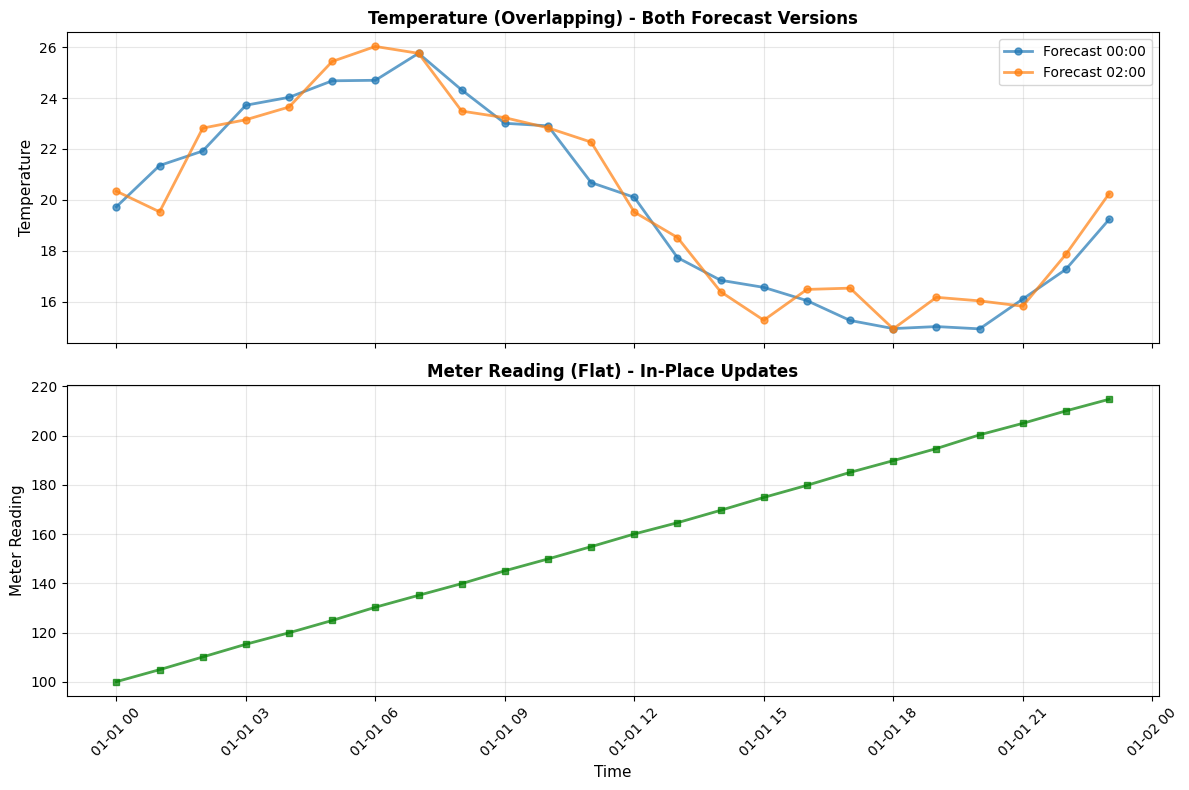

✓ Both time series plotted successfully!


In [5]:
# Plot both time series
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Temperature (overlapping series) - show BOTH forecasts
ax1 = axes[0]

# Get both versions from df_temp_all_versions
for knowledge_time in df_temp_all_versions.index.get_level_values('knowledge_time').unique():
    df_version = df_temp_all_versions.xs(knowledge_time, level='knowledge_time')
    temp_y = df_version['value'].astype(float)
    label = f"Forecast {knowledge_time.strftime('%H:%M')}"
    ax1.plot(df_version.index.get_level_values('valid_time'), temp_y, 
             marker='o', linewidth=2, markersize=5, alpha=0.7, label=label)

ax1.set_ylabel('Temperature', fontsize=11)
ax1.set_title('Temperature (Overlapping) - Both Forecast Versions', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Meter reading (flat series)
ax2 = axes[1]
meter_y = df_meter_read['value'].astype(float)
ax2.plot(df_meter_read.index, meter_y, marker='s', linewidth=2, markersize=5, 
         color='green', alpha=0.7)
ax2.set_ylabel('Meter Reading', fontsize=11)
ax2.set_xlabel('Time', fontsize=11)
ax2.set_title('Meter Reading (Flat) - In-Place Updates', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("✓ Both time series plotted successfully!")

## Part 3: Update a Flat Series (In-Place)

Flat series use **in-place updates** - there's no version history. The value is simply replaced.

This is ideal for correcting fact data like meter readings where you want to fix errors without maintaining a version trail.

In [6]:
# Update a flat series - simple, no batch_id needed!
update_time_flat = base_time + timedelta(hours=5)

# Read current value
original_meter_value = float(df_meter_read.loc[update_time_flat, 'value'])
print(f"Original meter reading at {update_time_flat}: {original_meter_value:.2f}")

# Update the flat series - just need series_id and valid_time!
corrected_meter_value = 130.0

result = td.get_series("meter_reading").update_records(updates=[{
    "valid_time": update_time_flat,
    "value": corrected_meter_value,
    "annotation": "Corrected: faulty meter reading",
    "changed_by": "technician@example.com",
}])

print(f"\nFlat update completed!")
print(f"  Updated: {original_meter_value:.2f} -> {corrected_meter_value:.2f}")
print(f"  Updated records: {len(result)}")

# Verify the update - read it back
df_meter_after = td.get_series("meter_reading").read(
    start_valid=update_time_flat,
    end_valid=update_time_flat + timedelta(hours=1),
)
print(f"\nVerification - current value: {float(df_meter_after.iloc[0]['value']):.2f}")

Original meter reading at 2025-01-01 05:00:00+00:00: 124.95

Flat update completed!
  Updated: 124.95 -> 130.00
  Updated records: 1

Verification - current value: 130.00


## Part 4: Update Overlapping Series (Versioned)

Overlapping series create **new versions** on each update - the old value is preserved with its original `knowledge_time`.

Since we now have **two batches** (two versions per valid_time), we can demonstrate three ways to identify which version to update:

1. **Using `batch_id`**: Target the latest version within a specific batch
2. **Using `knowledge_time`**: Target an exact version by its knowledge_time  
3. **Using just `valid_time`**: Target the latest version overall (most convenient!)

In [7]:
# We'll update three different time points using each method
update_time_1 = base_time + timedelta(hours=6)   # Method 1: batch_id
update_time_2 = base_time + timedelta(hours=12)  # Method 2: knowledge_time
update_time_3 = base_time + timedelta(hours=18)  # Method 3: just valid_time

# Show current values before updates
print("Current values BEFORE updates:\n")
for ut in [update_time_1, update_time_2, update_time_3]:
    versions = df_temp_all_versions.xs(ut, level='valid_time')
    print(f"  {ut}:")
    for knowledge_time, row in versions.iterrows():
        kt = knowledge_time if not isinstance(knowledge_time, tuple) else knowledge_time[0]
        print(f"    knowledge_time={kt}: {float(row['value']):.2f}")

# METHOD 1: Update using batch_id (targeting Batch 1)
print(f"\nMETHOD 1: batch_id — update {update_time_1} in Batch 1")
result_1 = td.get_series("temperature").update_records(updates=[{
    "batch_id": batch_id_1,
    "valid_time": update_time_1,
    "value": 29.0,
    "annotation": "Updated via batch_id (targeting Batch 1)",
    "tags": ["method_batch_id"],
    "changed_by": "demo@example.com",
}])
print(f"  Updated {len(result_1)} record (new version with knowledge_time=now())")

# METHOD 2: Update using knowledge_time (exact version lookup)
print(f"\nMETHOD 2: knowledge_time — update {update_time_2} from Batch 1 (knowledge_time={knowledge_time_1})")
result_2 = td.get_series("temperature").update_records(updates=[{
    "knowledge_time": knowledge_time_1,
    "valid_time": update_time_2,
    "value": 27.0,
    "annotation": "Updated via knowledge_time (exact version from Batch 1)",
    "tags": ["method_knowledge_time"],
    "changed_by": "demo@example.com",
}])
print(f"  Updated {len(result_2)} record")

# METHOD 3: Update using just valid_time (latest version)
print(f"\nMETHOD 3: valid_time only — update latest version at {update_time_3}")
result_3 = td.get_series("temperature").update_records(updates=[{
    "valid_time": update_time_3,
    "value": 25.0,
    "annotation": "Updated via latest lookup (most convenient!)",
    "tags": ["method_latest"],
    "changed_by": "demo@example.com",
}])
print(f"  Updated {len(result_3)} record")

Current values BEFORE updates:

  2025-01-01 06:00:00+00:00:
    knowledge_time=2025-01-01 00:00:00+00:00: 24.70
    knowledge_time=2025-01-01 02:00:00+00:00: 26.03
  2025-01-01 12:00:00+00:00:
    knowledge_time=2025-01-01 00:00:00+00:00: 20.10
    knowledge_time=2025-01-01 02:00:00+00:00: 19.52
  2025-01-01 18:00:00+00:00:
    knowledge_time=2025-01-01 00:00:00+00:00: 14.94
    knowledge_time=2025-01-01 02:00:00+00:00: 14.93

METHOD 1: batch_id — update 2025-01-01 06:00:00+00:00 in Batch 1
  Updated 1 record (new version with knowledge_time=now())

METHOD 2: knowledge_time — update 2025-01-01 12:00:00+00:00 from Batch 1 (knowledge_time=2025-01-01 00:00:00+00:00)
  Updated 1 record

METHOD 3: valid_time only — update latest version at 2025-01-01 18:00:00+00:00
  Updated 1 record


## Part 5: View All Versions (Version History)

Now let's read the overlapping series with `versions=True` to see all versions:
- Original Batch 1 values
- Revised Batch 2 values  
- Our new update versions (with `knowledge_time=now()`)

In [8]:
# Read all versions for the time points we updated
df_versions = td.get_series("temperature").read(
    start_valid=base_time + timedelta(hours=5),
    end_valid=base_time + timedelta(hours=20),
    versions=True,
)

print("All versions AFTER updates:\n")
for ut, method in [(update_time_1, 'batch_id'), (update_time_2, 'knowledge_time'), (update_time_3, 'valid_time')]:
    print(f"Valid time: {ut} (updated via {method})")
    try:
        versions = df_versions.xs(ut, level='valid_time')
        for idx, row in versions.iterrows():
            knowledge_time = idx if not isinstance(idx, tuple) else idx[0]
            value = float(row['value'])
            if knowledge_time == knowledge_time_1:
                source = "Batch 1 (original)"
            elif knowledge_time == knowledge_time_2:
                source = "Batch 2 (revised)"
            else:
                source = "UPDATE (new version)"
            print(f"  knowledge_time={knowledge_time} -> {value:.2f}  [{source}]")
    except KeyError:
        print(f"  No data for this time point")
    print()

print("Each update created a NEW version with knowledge_time=now().")
print("The original Batch 1 and Batch 2 values are preserved.")

All versions AFTER updates:

Valid time: 2025-01-01 06:00:00+00:00 (updated via batch_id)
  knowledge_time=2025-01-01 00:00:00+00:00 -> 24.70  [Batch 1 (original)]
  knowledge_time=2025-01-01 02:00:00+00:00 -> 26.03  [Batch 2 (revised)]
  knowledge_time=2026-02-23 13:48:15.598762+00:00 -> 29.00  [UPDATE (new version)]

Valid time: 2025-01-01 12:00:00+00:00 (updated via knowledge_time)
  knowledge_time=2025-01-01 00:00:00+00:00 -> 20.10  [Batch 1 (original)]
  knowledge_time=2025-01-01 02:00:00+00:00 -> 19.52  [Batch 2 (revised)]
  knowledge_time=2026-02-23 13:48:15.606498+00:00 -> 27.00  [UPDATE (new version)]

Valid time: 2025-01-01 18:00:00+00:00 (updated via valid_time)
  knowledge_time=2025-01-01 00:00:00+00:00 -> 14.94  [Batch 1 (original)]
  knowledge_time=2025-01-01 02:00:00+00:00 -> 14.93  [Batch 2 (revised)]
  knowledge_time=2026-02-23 13:48:15.610432+00:00 -> 25.00  [UPDATE (new version)]

Each update created a NEW version with knowledge_time=now().
The original Batch 1 and B

## Part 6: Visualize Original vs Updated

Let's plot both versions to see the changes visually.

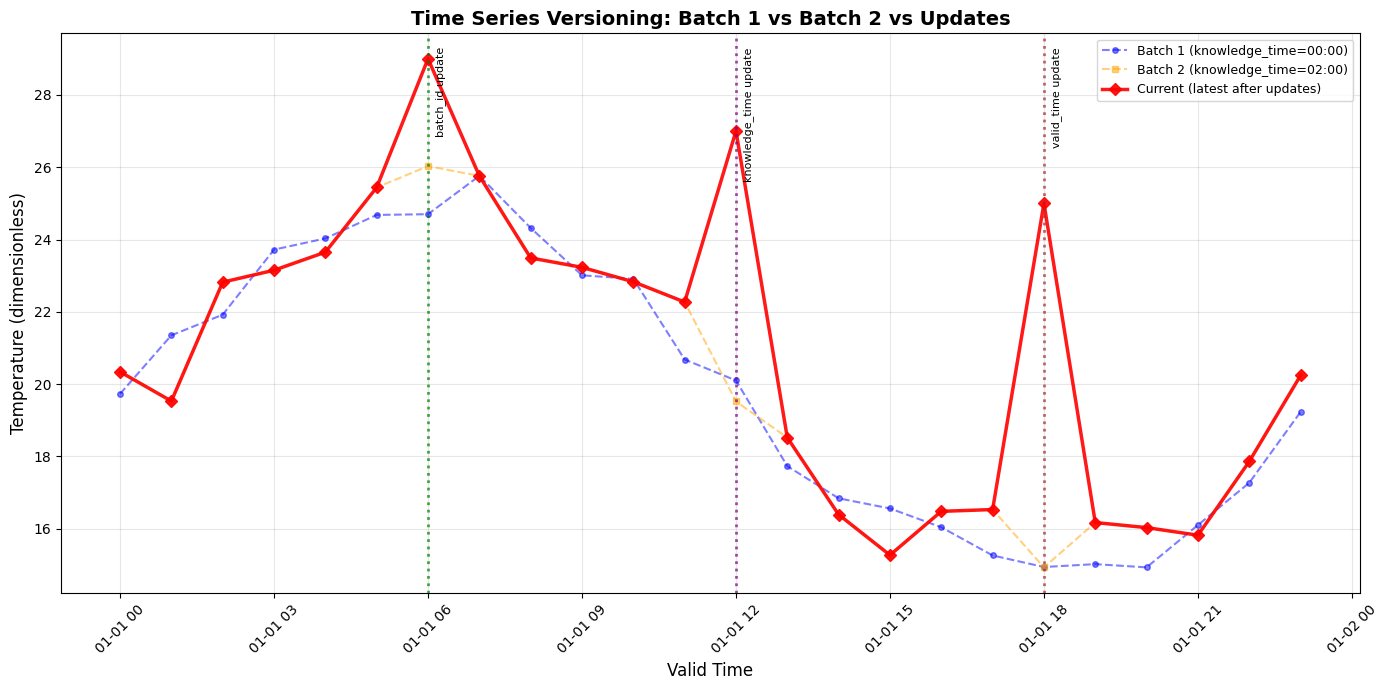

Dotted lines mark the three updated time points (hours 6, 12, 18)


In [9]:
# Read current (latest) version after all updates
df_current = td.get_series("temperature").read(
    start_valid=base_time,
    end_valid=base_time + timedelta(hours=24),
)

# Also read Batch 1 and Batch 2 values for comparison
# We can get them by reading all versions and filtering
df_all = td.get_series("temperature").read(
    start_valid=base_time,
    end_valid=base_time + timedelta(hours=24),
    versions=True,
)

# Plot comparison
plt.figure(figsize=(14, 7))

# Extract values from each batch
batch1_values = []
batch2_values = []
for vt in times:
    try:
        versions = df_all.xs(vt, level='valid_time')
        for kt, row in versions.iterrows():
            knowledge_time = kt if not isinstance(kt, tuple) else kt[0]
            if knowledge_time == knowledge_time_1:
                batch1_values.append(float(row['value']))
            elif knowledge_time == knowledge_time_2:
                batch2_values.append(float(row['value']))
    except KeyError:
        pass

# Plot Batch 1 (original)
plt.plot(times, batch1_values, 
         marker='o', linewidth=1.5, markersize=4, 
         label=f'Batch 1 (knowledge_time={knowledge_time_1.strftime("%H:%M")})', 
         color='blue', alpha=0.5, linestyle='--')

# Plot Batch 2 (revised)
plt.plot(times, batch2_values, 
         marker='s', linewidth=1.5, markersize=4, 
         label=f'Batch 2 (knowledge_time={knowledge_time_2.strftime("%H:%M")})', 
         color='orange', alpha=0.5, linestyle='--')

# Plot current (latest after updates)
current_y = df_current['value'].astype(float)
plt.plot(df_current.index, current_y, 
         marker='D', linewidth=2.5, markersize=6, 
         label='Current (latest after updates)', color='red', alpha=0.9)

# Highlight the updated points
for ut, label, color in [
    (update_time_1, 'batch_id update', 'green'),
    (update_time_2, 'knowledge_time update', 'purple'),
    (update_time_3, 'valid_time update', 'brown')
]:
    plt.axvline(x=ut, color=color, linestyle=':', linewidth=2, alpha=0.7)
    # Add annotation
    plt.annotate(label, xy=(ut, plt.ylim()[1]), xytext=(5, -10),
                 textcoords='offset points', fontsize=8, rotation=90, va='top')

plt.xlabel('Valid Time', fontsize=12)
plt.ylabel('Temperature (dimensionless)', fontsize=12)
plt.title('Time Series Versioning: Batch 1 vs Batch 2 vs Updates', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Dotted lines mark the three updated time points (hours 6, 12, 18)")

### Summary

- **Flat series**: in-place updates via `td.get_series("name").update_records(updates=[{"valid_time": dt, "value": ...}])`
- **Overlapping series**: versioned updates — creates new row with `knowledge_time=now()`, preserving originals
- **Three lookup methods** for overlapping: `batch_id`, `knowledge_time`, or just `valid_time` (targets latest)
- **Read versions**: `read(versions=True)` returns full audit trail with `(knowledge_time, valid_time)` index
- **Updateable fields**: `value`, `annotation`, `tags`, `changed_by`